Stats experiment for cum dists

In [2]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

pi = np.pi
exp = np.exp
sqrt = np.sqrt

got the dist
sigma = 0.29280860420665517 	1/sigma**2 = 11.663592320975715
amp 1.001972505653173


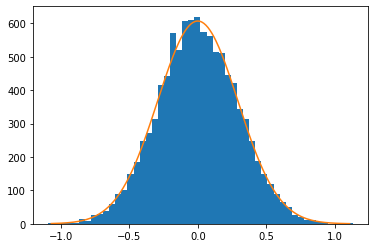

In [3]:
def get_cum_dist_from_unif(n_runs=1000,n_data=10000,delta=1.0):
    """a random variable x samples uniformly from (-delta/2,delta/2)  
    What is the distribution of the random variable X = sum(x) over n such instances? I couldn't figure it out so this function is to do some experiments."""
    big_x = np.random.uniform(low=-delta/2,high=delta/2, size=(n_runs,n_data))
    big_x = big_x.sum(axis=0)/sqrt(n_runs)
    return big_x

def plot_hist_from_dist(dist,n_data,b=50):
    n,bins,_ = plt.hist(dist,b,label="hist result experiment")
    bin_means = bins[1:] / 2 + bins[:-1] / 2
    bin_width = bins[1]-bins[0]
    gauss = lambda x,sigma,amp:amp*exp(-((x)/sigma)**2/2) / sqrt(2*pi*sigma**2) # assumes mean is zero, but not necessarily normalized
    popt,_ = curve_fit(gauss, bin_means, n/n_data/bin_width, p0=[1/sqrt(12),1.]) # 1/sqrt(12) ~ 0.2887
    # n/n_data/bin_width is because we want the total area under the curve to be 1.0 as all probability dists should be
    sigma,amp = popt
    print("sigma = {} \t1/sigma**2 = {}\namp {}".format(sigma,1/sigma**2,amp))
    x = np.linspace(bin_means[0],bin_means[-1],300)
    plt.plot(x, n_data * bin_width * gauss(x,sigma,amp),label="best fit gaussian")
    plt.show(block=True)
    return 

n_runs,n_data = 30000,10000
dist = get_cum_dist_from_unif(n_runs,n_data,delta=1.0)
print("got the dist")

plot_hist_from_dist(dist,n_data,b=50)

### Conclusion
It turns out that our random variable goes from being uniformly sampled from $[-\Delta/2,\Delta/2)$ with $\sigma = \Delta/\sqrt 12$, to a normal distribution (for large N `= n_runs`) with the same sigma.

What information can we gleam from the fact that our distribution $\widetilde g[t]$ is a real sequence?
We use our intuition from stat mech and count the number of states for each of the thingys. 

In [4]:
# fourier stuff
from numpy.fft import fft,rfft,ifft,irfft

In [5]:
arr = np.random.normal(0,1/sqrt(12),20)
arrc = arr * exp(1.j*np.random.uniform(0,2*pi,20))

In [6]:
import sys, os
sys.path.append("..")
import helper as h
from constants import SINC

def get_wnsqared_expected_values(ntap=2,lblock=4096):
    eigengrid = h.r_window_to_matrix_eig(SINC,ntap=ntap,lblock=lblock) # h.window_pad_to_box_rfft(SINC,pad_factor=10.0)
    eigengrid_hann = h.r_window_to_matrix_eig(SINC * np.hanning(len(SINC)),ntap=ntap,lblock=lblock)
    eigengrid_hamm = h.r_window_to_matrix_eig(SINC * np.hamming(len(SINC)),ntap=ntap,lblock=lblock)

    plt.imshow(abs(eigengrid),aspect="auto")
    plt.show()

    plt.subplots(figsize=(10,5))
    plt.subplot(121)
    plt.semilogy(np.mean(1/abs(eigengrid**2),axis=1),".",label="sinc")
    plt.semilogy(np.mean(1/abs(eigengrid_hann**2),axis=1),".",alpha=0.4,label="sinc hanning")
    plt.semilogy(np.mean(1/abs(eigengrid_hamm**2),axis=1),".",alpha=0.4,label="sinc hamming")
    plt.title("All terms Log Scale")
    plt.ylabel("R[n]")
    plt.xlabel("n")
    plt.grid(which="both")
    plt.legend()

    plt.subplot(122)
    plt.plot(np.mean(1/abs(eigengrid[:1000]**2),axis=1),".",label="sinc")
    plt.plot(np.mean(1/abs(eigengrid_hann[:1000]**2),axis=1),".",alpha=0.4,label="sinc hanning")
    plt.plot(np.mean(1/abs(eigengrid_hamm[:1000]**2),axis=1),".",alpha=0.4,label="sinc hamming")
    plt.title("First few terms")
    plt.ylabel("R[n]")
    plt.xlabel("n")
    plt.legend()
    plt.suptitle("Quantization Error Increase from Inverse PFB\nntap={} lblock={}".format(ntap,lblock),fontsize=18)
    plt.tight_layout()
    plt.show()
    
    return np.mean(1/abs(eigengrid_hann)**2,axis=1)


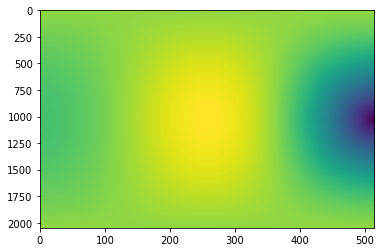

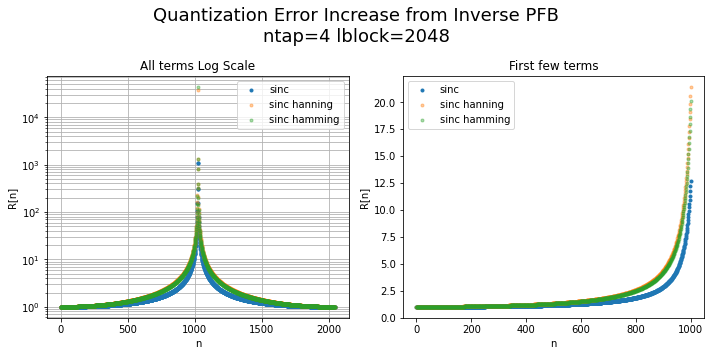

In [7]:
wn_means_hann = get_wnsqared_expected_values(4,2048)

In [8]:
max(wn_means_hann),wn_means_hann.shape,np.argmax(wn_means_hann)

(36855.254, (2048,), DeviceArray(1024, dtype=int32))

In [9]:
print("the worse data point",wn_means_hann[1024:1025])
idx_worst = [1024]
print("5 worst data points",wn_means_hann[1022:1027])
idx_worst_5 = np.arange(1022,1028)
print("1% (21) worst data points",wn_means_hann[1024-10:1025+10])
idx_worst_1perc = np.arange(1024-10,1025+10)
idx_worst_3perc = np.arange(1024-30,1025+20) + 5 # offset determined visually 

the worse data point [36855.254]
5 worst data points [  399.78125  1325.5624  36855.254     805.4821    327.51645]
1% (21) worst data points [   56.10971     62.946594    71.67717     83.20604     99.11957
   122.46099    159.88745    229.18745    399.78125   1325.5624
 36855.254      805.4821     327.51645    203.03578    146.55074
   114.42883     93.769264    79.39399     68.82681     60.736656
    54.347214]


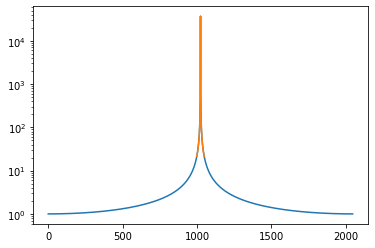

In [10]:
plt.semilogy(wn_means_hann)
plt.semilogy(idx_worst_3perc,wn_means_hann[idx_worst_3perc])

In [11]:
print("currently the root mean squared is",sqrt(wn_means_hann.mean()))
wm = wn_means_hann.copy()
# rep_idx_with_zeros = lambda arr,idxs:np.concatenate([arr[:idxs[0]],np.ones(len(idxs)),arr[idxs[-1]:]])
# wm = rep_idx_with_zeros(wm,idx_worst)
# print("if we take out the worse numbers the rms is",sqrt(wm.mean()))
# wm = rep_idx_with_zeros(wm,idx_worst_5)
# print("if we take out the worst five it becomes",sqrt(wm.mean()))
# wm = rep_idx_with_zeros(wm,idx_worst_1perc)
# print("replacing 1% of the worst idxs we get",sqrt(wm.mean()))
# wm = rep_idx_with_zeros(wm,idx_worst_3perc)
# print("replacing 3% of the worst idxs we get rms=",sqrt(wm.mean()))


currently the root mean squared is 4.784479


In [12]:
sqrt(max(wm))

191.97722

In [13]:
191**2

36481

# Simulate what effect doing an RFFT does to quantization noise

In [14]:
import numpy as np
from numpy.fft import rfft,irfft

sqrt = np.sqrt
exp = np.exp

In [15]:
def mse(signal,noisy_signal):
    # returns the mean squared error, also takes complex input
    return np.mean(abs(signal-noisy_signal)**2)

After quantization, the first step of the inversion is to invert the real-DFT (on each row of the quantization)
We're inverting the F from FSW in the matrix notation of the DFT

In [16]:
l = 10000
delta = 0.1 # quantization step
h = np.random.normal(0,1,l) # simulated signal, the output of SW
fh = rfft(h) / sqrt(l) # the output signal of the pfb (FSW) 
fh_noisy = fh + np.random.uniform(-delta/2,delta/2,l//2+1) + 1.0j*np.random.uniform(-delta/2,delta/2,l//2+1) # quantization noise
h_noisy = irfft(fh_noisy) * sqrt(l)
print("mean squared error of the quantized signal {}".format(mse(fh,fh_noisy)))
print("mean squared error after doing irfft signal {}".format(mse(h,h_noisy)))
print("How close are they to delta squared over 6? (Expect 1.0)\n{}".format(mse(fh,fh_noisy) / (delta**2/6)))
print("{}".format(mse(h,h_noisy) / (delta**2/6)))

mean squared error of the quantized signal 0.0016550314701733444
mean squared error after doing irfft signal 0.0016551703256470858
How close are they to delta squared over 6? (Expect 1.0)
0.9930188821040065
0.9931021953882513


the output of the above codeblock shows that the MSE is equivalent to $\Delta^2/ 6$ (run it multiple times)

The second step is to apply DFT on each column to turn $h_n[t]$ into $H_n[\xi]$, this does not change the error

In [17]:
l = 10000
h = np.random.normal(0,1,l) # long random signal
delta = 0.1 # quantization step
# add noise to the signal
h_noisy = h + np.random.uniform(-delta/2,delta/2,l) + 1.0j*np.random.uniform(-delta/2,delta/2,l)
H = rfft(h) # rfft the original signal
H_noisy = irfft(h_noisy) # and the noisy signal

In [18]:
# def mse(signal,noisy_signal):
#     # returns the mean squared error, input can be real or complex


# new matrix inversion method 

In [19]:
import helper as h
from constants import SINC

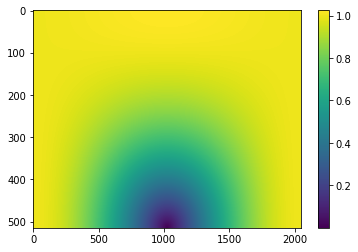

In [20]:
mat_eig = h.r_window_to_matrix_eig(SINC * np.hanning(len(SINC)))
m = abs(np.array(mat_eig))
plt.imshow(m.T,aspect="auto")
plt.colorbar()
plt.show()
ntot = m.shape[0]*m.shape[1]

n eigenvalues below 0.197737507 is 10546
which ammounts to 0.9998862257281552% of all eigenvalue

eigen matrix shape =  (2048, 515)


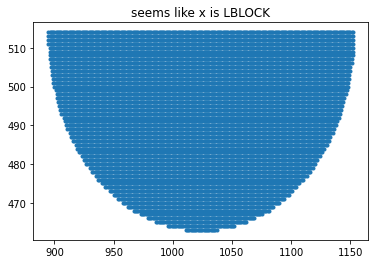

In [21]:
# trial and error what can we do with an extra 1% bandwidth
eigen_thresh = 0.197737507 # this is closets we can ever get to exactly 1% of datapoints
idxs_1perc = np.nonzero(m<eigen_thresh)
nbad = len(np.nonzero(m<eigen_thresh)[0])
print("n eigenvalues below {} is {}\nwhich ammounts to {}% of all eigenvalue".format(eigen_thresh,
                                                                                    nbad,
                                                                                    nbad/ntot*100))
print("\neigen matrix shape = ",m.shape)
# to figure out which is x and which is y
plt.figure()
plt.plot(idxs_1perc[0],idxs_1perc[1],".")
plt.title("seems like x is LBLOCK")
plt.show()

In [22]:
# trial and error what can we do with an extra 3% bandwidth
eigen_thresh = 0.3377
nbad = len(np.nonzero(m<eigen_thresh)[0])
print("n eigenvalues below {} is {}\nwhich ammounts to {}% of all eigenvalue".format(eigen_thresh,
                                                                                    nbad,
                                                                                    nbad/ntot*100))

n eigenvalues below 0.3377 is 31636
which ammounts to 2.9994690533980584% of all eigenvalue


In [23]:
# idxs = np.nonzero(m<0.1977)
# # idxs = np.nonzero(m<0.3377)
# plt.figure(figsize=(13,13))
# plt.plot(m[idxs],".")

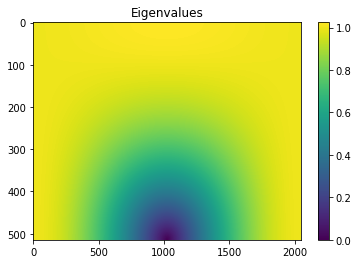

In [24]:
m[0,0] = 0.0
plt.imshow(m.T,aspect="auto")
plt.title("Eigenvalues")
plt.colorbar()
# plt.savefig("eigenvalues.png")
plt.show()

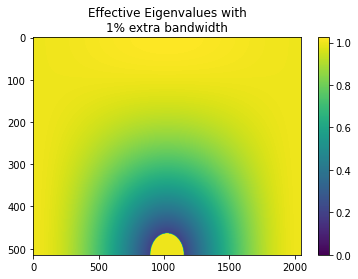

In [25]:
idxs = np.nonzero(m<0.1977)
mcopy = m.copy()
mcopy[idxs] = np.ones(len(idxs[0]))
mcopy[0,0] = 0.0
plt.imshow(mcopy.T,aspect="auto")
plt.title("Effective Eigenvalues with\n1% extra bandwidth")
plt.colorbar()
# plt.savefig("effective_eigenvalues_1perc_extra_bandwidth.png")
plt.show()

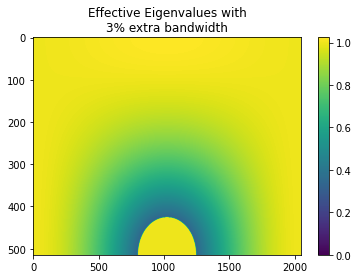

In [34]:
idxs = np.nonzero(m<0.3377)
mcopy = m.copy()
mcopy[idxs] = np.ones(len(idxs[0]))
mcopy[0,0] = 0.0
plt.imshow(mcopy.T,aspect="auto")
plt.title("Effective Eigenvalues with\n3% extra bandwidth")
plt.colorbar()
# plt.savefig("effective_eigenvalues_3perc_extra_bandwidth.png")
plt.show()

In [55]:
mcopy.T.shape

(515, 2048)

In [52]:
np.repeat(np.arange(5),5,axis=0)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4])

In [54]:
np.repeat([np.arange(5)],5,axis=0).flatten()

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
       2, 3, 4])

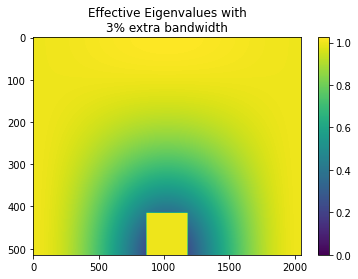

In [105]:
idxs[0].shape
n_pix = 31637
height = 100
width = 316 # n_pix // height

x_pix = np.repeat(np.arange(2048//2 - width//2, 2048//2 + width//2),height,axis=0) 
y_pix = np.repeat([np.arange(514,514-height,-1)],width,axis=0).flatten()

idxs = (x_pix,y_pix)
mcopy = m.copy()
mcopy[idxs] = np.ones(len(idxs[0]))
mcopy[0,0] = 0.0
plt.imshow(mcopy.T,aspect="auto")
plt.title("Effective Eigenvalues with\n3% extra bandwidth")
plt.colorbar()
plt.savefig("effective_eigenvalues_3perc_extra_bandwidth_implementable.png")
plt.show()

In [100]:
316/np.sqrt(3) , 100/np.sqrt(3) , 182 * 58 , 208 * 51

(182.44268506392174, 57.73502691896258, 10556, 10608)

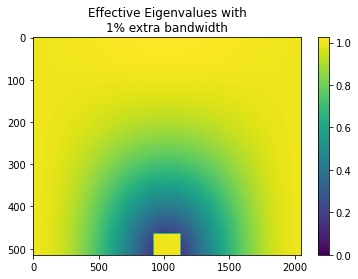

In [104]:
idxs[0].shape
n_pix = 31637
height = 51
width = 208 # n_pix // height

x_pix = np.repeat(np.arange(2048//2 - width//2, 2048//2 + width//2),height,axis=0) 
y_pix = np.repeat([np.arange(514,514-height,-1)],width,axis=0).flatten()

idxs = (x_pix,y_pix)
mcopy = m.copy()
mcopy[idxs] = np.ones(len(idxs[0]))
mcopy[0,0] = 0.0
plt.imshow(mcopy.T,aspect="auto")
plt.title("Effective Eigenvalues with\n1% extra bandwidth")
plt.colorbar()
# plt.savefig("effective_eigenvalues_1perc_extra_bandwidth_implementable.png")
plt.show()

In [92]:
mcopy.shape[1] / height # only save 1 in every 10th data point! Ugh

10.098039215686274

In [70]:
mcopy.shape[1] / height 

5.15

Unfortunately the inverse matrix eigenmethod doesn't work, back to the drawing board.

# reconstructing the with an inverse matrix

In [27]:
from numpy.fft import fft,ifft

In [28]:
a = np.arange(5)
idx = np.array([1,2])
a[idx] = np.array([2,1])
print(a)

[0 2 1 3 4]


In [29]:
k = 1000
n_known_indices = k//10 # 10%
sigma_noise = 0.01

# simulates a single run with the params above
def simulate_error(verbose=False):
    g = np.random.normal(0,1,k)
    G = fft(g) / sqrt(k)
    W = np.sqrt(np.linspace(0.05,1,k)) # roughly represents the eigenvalues
    H = G * W
    qnoise = np.random.normal(0,sigma_noise,k) * exp(np.random.uniform(0,2*pi))
    H_noisy = H + qnoise

    G0 = H_noisy / W # first guess at G, quite noisy in places
    mseG0 = np.ones(k) * sigma_noise**2 / W**2

    g0_tilde = ifft(G0 * sqrt(k)) # first guess at reconstructing g
    mseg0_tilde = np.ones(k) * sigma_noise**2 * np.mean(1/W**2)

    # replace some of the values of g0 with actual values of g0
    idxs = np.arange(n_known_indices) # indices to replace in g
    g0,mseg0 = g0_tilde.copy(), mseg0_tilde.copy() 
    g0[idxs] = g[idxs]
    mseg0[idxs] = np.zeros(n_known_indices)

    G1_tilde = fft(g0) / sqrt(k)
    mseG1_tilde = mseg0_tilde * (k - n_known_indices) / sqrt(k)

    # combine G1_tilde and G0 into a final guess
    G1 = (G1_tilde / mseG1_tilde + G0 / mseG0) / (1/mseG1_tilde + 1/mseG0)
    mseG1 = 1 / (1/mseG1_tilde + 1/mseG0)

    # final guess at g
    g1 = ifft(G1 * sqrt(k))
    mseg1 = np.ones(k) * np.mean(sqrt(mseG1))**2
    if verbose:
        plt.plot(g)
        plt.title("g")
        plt.show()
        plt.plot(abs(g0))
        plt.title("g0")
        plt.show()
        plt.plot(abs(g1))
        plt.title("g1")
        plt.show()
        plt.plot(abs(G))
        plt.title("G")
        plt.show()
        plt.plot(abs(G0))
        plt.title("G0")
        plt.show()
        plt.plot(abs(G1))
        plt.title("G1")
        plt.show()
        input("[Enter]") 
    return g,g0,g1,mseg0,mseg1,G,G0,G1,mseG0,mseG1

g_arr,g0_arr,g1_arr,G_arr,G0_arr,G1_arr = [],[],[],[],[],[] # 2d arrays 
_,_,_,mseg0,mseg1,_,_,_,mseG0,mseG1 = simulate_error()
for i in range(int(10**3)):
    g,g0,g1,_,_,G,G0,G1,_,_ = simulate_error(verbose=False)
    g_arr.append(g)
    g0_arr.append(g0)
    g1_arr.append(g1)
    G_arr.append(G)
    G0_arr.append(G0)
    G1_arr.append(G1)
g_arr,g0_arr,g1_arr = np.array(g_arr),np.array(g0_arr),np.array(g1_arr)
G_arr,G0_arr,G1_arr = np.array(G_arr),np.array(G0_arr),np.array(G1_arr)

mseg0_exp = np.mean(abs(g_arr - g0_arr)**2,axis=0) # exp for experimentally determined
mseg1_exp = np.mean(abs(g_arr - g1_arr)**2,axis=0)
mseG0_exp = np.mean(abs(G_arr - G0_arr)**2,axis=0)
mseG1_exp = np.mean(abs(G_arr - G1_arr)**2,axis=0)


In [30]:
block = abs(g_arr - g0_arr)**2

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


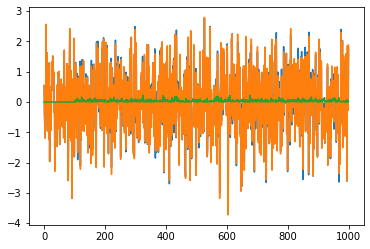

In [31]:
plt.plot(g_arr[0])
plt.plot(g0_arr[0])
plt.plot(abs(g_arr[0]-g0_arr[0])**2)

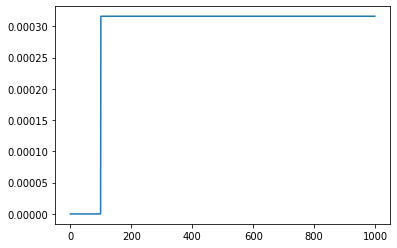

In [32]:
plt.plot(mseg0)

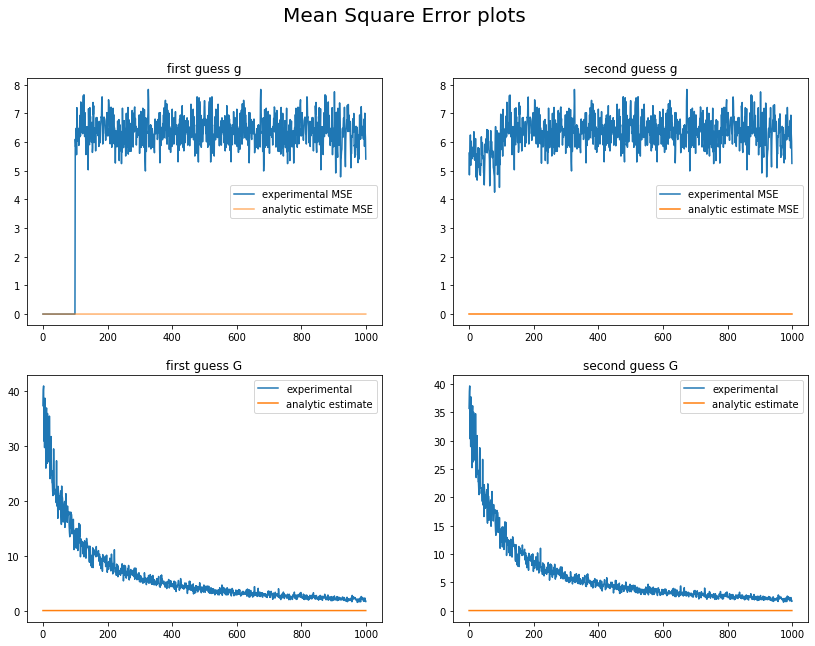

In [33]:
plt.subplots(2,2,figsize=(14,10)) 
plt.subplot(221)
plt.title("first guess g")
plt.plot(mseg0_exp,label="experimental MSE")
plt.plot(mseg0,alpha=0.6,label="analytic estimate MSE")
# plt.plot(mseg0_exp - mseg0,alpha=0.5,label="diff")
plt.legend()

plt.subplot(222)
plt.title("second guess g")
plt.plot(mseg1_exp,label="experimental MSE")
plt.plot(mseg1,label="analytic estimate MSE")
# plt.plot(mseg1_exp - mseg1,label="diff")
plt.legend()

plt.subplot(223)
plt.title("first guess G")
plt.plot(mseG0_exp,label="experimental")
plt.plot(mseG0,label="analytic estimate")
# plt.plot(mseG0_exp - mseG0,label="diff")
plt.legend()

plt.subplot(224)
plt.title("second guess G")
plt.plot(mseG1_exp,label="experimental")
plt.plot(mseG1,label="analytic estimate")
# plt.plot(mseG1_exp - mseG1,label="diff")
plt.legend()

plt.suptitle("Mean Square Error plots",fontsize=20)
plt.show()